In [1]:
import os
os.chdir('/Users/ericehlert/rp')

import pandas as pd

from src.functions.get_json_multiple import get_json_multiple
from src.functions.extract_and_process_cells import extract_and_process_cells
from src.functions.extract_tables import extract_tables

In [2]:
json_files = get_json_multiple('textract')
cells_df = extract_and_process_cells(json_files)
tables_df = extract_tables(json_files, cells_df)

Extracted Cells DataFrame has 51062 rows and 21 columns
Processed Cells DataFrame has 51062 rows and 23 columns
Derived Tables DataFrame has 1160 rows and 23 columns


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
tables_df.columns

In [4]:
scaler = StandardScaler()

num_features = tables_df[
    [
        #'table_width', 
        #'table_height', 
        #'cell_count', 
        #'row_count', 
        #'column_count',
        'entity_column_header',
        'entity_table_title',
        'entity_table_section_title',
        'entity_table_footer',
        'entity_table_summary',
        'child_count', 
        'merged_cell_count', 
        'table_title_count', 
        'table_footer_count'
    ]
]

# Filling missing values with 0 and scale
num_features_filled = num_features.fillna(0)
num_features_scaled = scaler.fit_transform(num_features_filled)
num_features_scaled_df = pd.DataFrame(num_features_scaled, columns=num_features.columns)

num_features_scaled_df.head()

,entity_column_header,entity_table_title,entity_table_section_title,entity_table_footer,entity_table_summary,child_count,merged_cell_count,table_title_count,table_footer_count
0,0.827990,0.0,0.0,0.0,-0.154371,1.337491,-0.116522,-0.457814,-0.2231
1,2.710524,0.0,0.0,0.0,-0.154371,2.273074,-0.116522,-0.457814,-0.2231
2,-0.678037,0.0,0.0,0.0,-0.154371,-0.492096,-0.116522,-0.457814,-0.2231
3,-0.678037,0.0,0.0,0.0,-0.154371,-0.575259,-0.116522,-0.457814,-0.2231
4,-0.678037,0.0,0.0,0.0,-0.154371,-0.575259,-0.116522,-0.457814,-0.2231


In [5]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(num_features_scaled_df)

pca_feature_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(n_components)])
pca_feature_df.head()

,PC1,PC2
0,1.452866,-0.408719
1,3.308157,-0.347673
2,-0.745965,-0.368439
3,-0.800934,-0.361584
4,-0.800934,-0.361584


In [6]:
table_type_dummies_df = pd.get_dummies(tables_df['table_type'], prefix='table_type', drop_first=True)
table_type_dummies_df.head()

,table_type_STRUCTURED_TABLE
0,True
1,True
2,False
3,False
4,False


In [7]:
training_features_df = pd.concat([pca_feature_df, table_type_dummies_df], axis=1)
training_features_df.head()

,PC1,PC2,table_type_STRUCTURED_TABLE
0,1.452866,-0.408719,True
1,3.308157,-0.347673,True
2,-0.745965,-0.368439,False
3,-0.800934,-0.361584,False
4,-0.800934,-0.361584,False


In [8]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

The best silhouette score is 0.8998317077089484, with 10 clusters


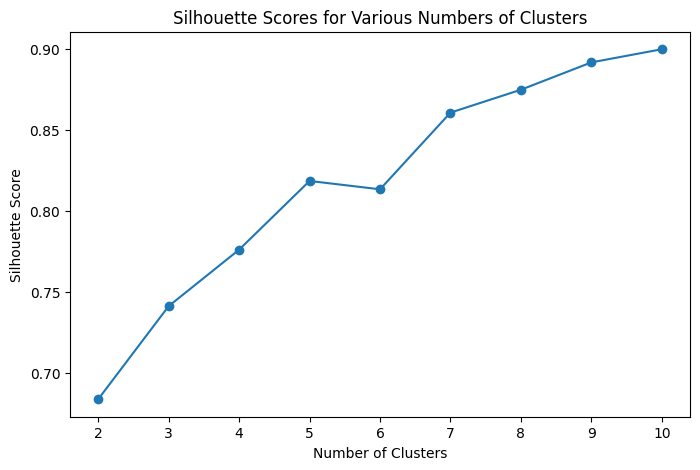

In [9]:
# Range of clusters to try
cluster_range = range(2, 11)

silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(training_features_df)
    silhouette_avg = silhouette_score(training_features_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    #print(f"Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

optimal_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The best silhouette score is {max(silhouette_scores)}, with {optimal_n_clusters} clusters")

# Plotting silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [10]:
# Using the optimal number of clusters determined by silhouette score
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42)
tables_df['cluster_label'] = kmeans_optimal.fit_predict(training_features_df)

# Displaying the cluster labels
tables_df.head(1)

,table_id,table_width,table_height,table_left,table_top,table_page,source,cell_count,row_count,column_count,...,entity_table_section_title,entity_table_footer,entity_table_summary,child_count,merged_cell_count,table_title_count,table_footer_count,table_type,layout_title_text,cluster_label
0,0053c7f9-3f4c-45fd-9810-46acf4996d74,0.884706,0.648113,0.055816,0.231789,9,textract_results_932439d3a7b5afd66ecfc1d716b29...,108,27,4,...,0,0,0,108,0,0,0,STRUCTURED_TABLE,NaN,0


In [11]:
from sklearn.metrics.pairwise import euclidean_distances

centroids = kmeans_optimal.cluster_centers_
distances = euclidean_distances(training_features_df, centroids)
min_distances = distances.min(axis=1)

tables_df['distance_to_centroid'] = min_distances

# Group by cluster label
grouped = tables_df.groupby('cluster_label')['distance_to_centroid']

# Calculate mean distance within each cluster
mean_distances = grouped.mean()

# Calculate standard deviation of distances within each cluster
std_distances = grouped.std()

# Optionally, merge these statistics back into the original DataFrame for further analysis
tables_df = tables_df.merge(mean_distances.rename('mean_distance'), left_on='cluster_label', right_index=True)
tables_df = tables_df.merge(std_distances.rename('std_distance'), left_on='cluster_label', right_index=True)

threshold_factor = 3  # Customize based on your data analysis

# Calculate the outlier flag
tables_df['outlier_flag_2std'] = tables_df['distance_to_centroid'] > (tables_df['mean_distance'] + threshold_factor * tables_df['std_distance'])

In [12]:
tables_df.to_csv('tables_df.csv', index=False)

In [ ]:
# Using a specific number of clusters determined by silhouette score
kmeans_optimal = KMeans(n_clusters=8, random_state=42)
tables_df['cluster_label'] = kmeans_optimal.fit_predict(training_features_df)

# Displaying the cluster labels
tables_df.head(1)

In [ ]:
# Assuming 'tables_df' contains your original data plus a 'cluster_label' column indicating the cluster assignment
summary_stats = tables_df.groupby('cluster_label').describe()

# To view summary statistics for a specific cluster (e.g., cluster 0)
summary_stats.to_csv('summary_stats.csv')